# Hello, Numerai

Hello and welcome to the Numerai Data Science Tournament!

This notebook is designed to help you build your first machine learning model and start competing the tournament.

In this notebook we will
1. Download and explore the Numerai dataset
2. Train and evaluate your first machine learning model
3. Deploy your model to start making live submissions

In [1]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle

# Inline plots
%matplotlib inline

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time.

Each row represents a stock at a specific point in time, where `id` is the stock id and the `era` is the date. The `features` describe the attributes of the stock (eg. P/E ratio) known on the date and the `target` is a measure of 20-day returns.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Downloading the dataset
Let's download the historical training data and take a closer look.

In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest dataset
[f for f in napi.list_datasets() if f.startswith("v4.2")]

['v4.2/features.json',
 'v4.2/live_example_preds.csv',
 'v4.2/live_example_preds.parquet',
 'v4.2/live_int8.parquet',
 'v4.2/meta_model.parquet',
 'v4.2/train_int8.parquet',
 'v4.2/validation_example_preds.csv',
 'v4.2/validation_example_preds.parquet',
 'v4.2/validation_int8.parquet']

In [3]:
import pandas as pd
import json

# Download the training data and feature metadata
# This will take a few minutes 🍵
napi.download_dataset("v4.2/train_int8.parquet");
napi.download_dataset("v4.2/features.json");

# Load only the "medium" feature set to reduce memory usage and speedup model training (required for Colab free tier)
# Use the "all" feature set to use all features
feature_metadata = json.load(open("v4.2/features.json"))
feature_cols = feature_metadata["feature_sets"]["medium"]
train = pd.read_parquet("v4.2/train_int8.parquet", columns=["era"] + feature_cols + ["target"])

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]
train

v4.2/train_int8.parquet: 1.88GB [01:28, 21.3MB/s]                            
v4.2/features.json: 1.03MB [00:00, 2.66MB/s]                           


,era,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_additive_untrustworthy_hierologist,feature_adsorbed_blizzardy_burlesque,feature_affettuoso_taxidermic_greg,...,feature_wistful_tussive_cycloserine,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,target
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0,4,0,4,2,0,1,4,0,...,4,0,0,2,4,2,4,2,2,0.25
n003bee128c2fcfc,0001,4,2,2,2,2,3,1,3,2,...,3,3,3,2,0,2,2,3,2,0.75
n0048ac83aff7194,0001,4,4,2,0,2,0,4,1,3,...,0,0,1,2,0,2,3,1,2,0.25
n00691bec80d3e02,0001,1,4,1,1,2,0,2,1,2,...,0,2,1,2,2,2,3,2,2,0.75
n00b8720a2fdc4f2,0001,0,2,0,0,2,0,3,1,0,...,3,1,1,2,0,2,0,1,2,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,4,2,4,4,3,1,0,4,4,...,4,4,1,2,1,3,2,2,1,0.25
nffc7d24176548a4,0573,0,3,3,4,2,0,3,1,3,...,2,2,0,2,4,2,0,1,2,0.50
nffc9844c1c7a6a9,0573,4,1,1,2,0,3,4,0,0,...,1,1,3,0,3,0,2,0,1,0.50


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

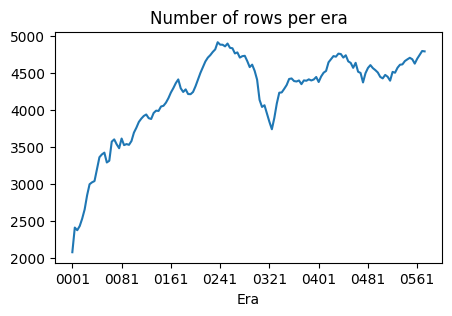

In [4]:
# Plot the number of rows per era
train.groupby("era").size().plot(title="Number of rows per era", figsize=(5, 3), xlabel="Era");

### Features
As mentioned above, `features` are quantitative attributes of each stock: fundamentals like P/E ratio, technical signals like RSI, market data like short interest, secondary data like analyst ratings, and much more.

The underlying definition of each feature is not important, just know that Numerai has included these features in the dataset because we believe they are predictive of the `target`.

In [5]:
# Number of features
len(feature_cols)

583

Feature values are binned into 5 equal bins: `0`, `1`, `2`, `3`, `4`. This heavy regularization of feature values is to avoid overfitting as the underlying values are extremely noisy.

If data for a particular feature is missing for that era (more common in early `eras`), then all values will be set to `2`.

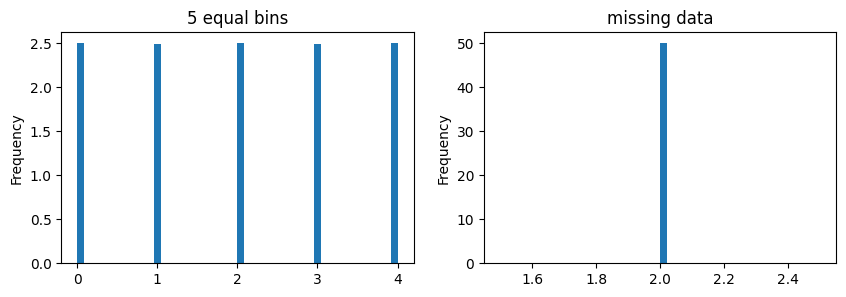

In [6]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_cols[-1]].plot(kind="hist", title="5 equal bins", density=True, bins=50, ax=ax1);
first_era[feature_cols[-1]].plot(kind="hist", title="missing data", density=True, bins=50, ax=ax2);

### Target
The `target` is a measure of 20-day stock market returns. Specifically, it is a measure of "stock-specific" returns that are not "explained" by broader trends in the market, country, sector, or well-known "factors".

Target values are binned into 5 unequal bins: `0`, `0.25`, `0.5`, `0.75`, `1.0`. Again, this heavy regularization of target values is to avoid overfitting as the underlying values are extremely noisy.

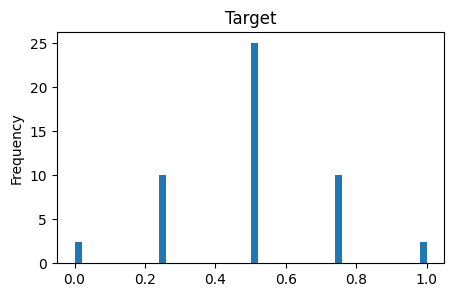

In [7]:
# Plot density histogram of the target
train["target"].plot(kind="hist", title="Target", figsize=(5, 3), xlabel="Value", density=True, bins=50);

## 2. Modeling
At a high level, our task is to model and predict the `target` variable.

### Model training

You are free to use any tool or framework, but here we will be using LGBMRegressor, a popular choice amongst tournament participants.

While you wait for the model to train, watch this [video](https://www.youtube.com/watch?v=w8Y7hY05z7k) to learn why tree-based models work so well on tabular datasets from our Chief Scientist MDO.

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
import lightgbm as lgb

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  min_data_in_leaf=1000,
  learning_rate=0.01,
  max_depth=5,
  min_gain_to_split = 0.1,
  bagging_fraction=0.3,
  bagging_freq=10,
  num_leaves= 20,
  colsample_bytree=0.1
)

# This will take a few minutes 🍵
model.fit(
  train[feature_cols],
  train["target"]
);

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of dat

### Validation predictions

Now let's make some out-of-sample predictions on the validation dataset to evaluate our model's performance.

In [ ]:
# Download validation data
# This will take a few minutes 🍵
napi.download_dataset("v4.2/validation_int8.parquet");

# Load the validation data, filtering for data_type == "validation"
validation = pd.read_parquet("v4.2/validation_int8.parquet", columns=["era", "data_type"] + feature_cols + ["target"])
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (higher memory usage, slower inference, more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 4 weeks into the future, so we need to "embargo" the 4 eras following our last train era to avoid data leakage.
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_cols])
validation[["era", "prediction", "target"]]

### Performance evaluation
The primary scoring metric in Numerai is called `numerai_corr` or `CORR`, which is a Numerai specific variant of the Pearson Correlation Coefficient.

This metric is designed to "align incentives" between model and hedge fund performance. A model with a good `CORR` score should help the hedge fund make good returns.

On the Numerai website you will also see this score referred to as `CORR20V2`, where the "20" refers to the 20-day return target and "v2" specifies that we are using the 2nd version of the scoring function.

In [ ]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

As mentioned above, it is important for us to score each historical `era` independantly. So when evaluating the performance of our model, we should be looking at the "per era" `corr`.

One thing you may notice here is how low the scores are (in the range of +/- 5% correlation). This is very normal in the domain of quantitative finance and is part of the reason why we say Numerai is the "hardest data science tournament" in the world.

In [ ]:
# Compute the per-era correlation between our predictions and the target values
per_era_corr = validation.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))

# Plot the per-era correlation
per_era_corr.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[], snap=False);

Instead of looking at the `corr` score for each era, it is helpful to look at the cumulative `corr`.

If you are familiar with "backtesting" in quant finance where people simulate the historical performance of their investment strategies, you can roughly think of this plot as a backtest of your model performance over the historical validation period.

In [ ]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));

### Performance metrics

To evaluate the performance of our model, it is also helpful to compute some summary metrics over the entire validation period.

`Mean` of correlations is the primary measure of your model's performance.

`Sharpe` is a measure of your model's consistency, a concept borrowed from finance where it usually refers to risk adjusted returns of an investment strategy. In Numerai, we compute sharpe as the average correlation divided by the standard deviation of correlations.

`Max drawdown` is a measure of your model's risk, another concept borrowed from finance where it usually refers to the maximum financial loss suffered by an investment strategy. In Numerai, we compute max drawdown as the maximum peak to trough drop in cumulative validation correlation.

In [ ]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

pd.DataFrame({
    "mean": corr_mean,
    "std": corr_std,
    "sharpe": corr_sharpe,
    "max_drawdown": max_drawdown
}, index=["Value"]).T

These performance metrics above is not amazing but good enough for us to get started. Don't worry, we will be learning how to improve our model performance in the next tutorials!

## 3. Submissions

Unlike Kaggle competitions that evalute models based on <ins>test</ins> performance, Numerai evaluates models based based on <ins>live</ins> performance.

### Live predictions

Every Tuesday-Saturday, new `live features` are released, which represent the current state of the stock market.

Your task is to generate `live predictions` on the unknown target values, which represent stock market returns 20 days into the future.

In [ ]:
# Download latest live features
napi.download_dataset("v4.2/live_int8.parquet")

# Load live features
live_features = pd.read_parquet(f"v4.2/live_int8.parquet", columns=feature_cols)

# Generate live predictions
live_predictions = model.predict(live_features[feature_cols])

# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")

### Model upload

To participate in the tournament, you must submit live predictions every Tuesday-Saturday.

To automate this process, you can simply:
- Define your prediction pipeline as a function
- Serialize your function using the `cloudpickle` library
- Upload your model pickle file to Numerai
- Let Numerai run your model to submit live predictions every day

Read more about Model Uploads and other self-hosted automation options in our [docs](https://docs.numer.ai/numerai-tournament/submissions#automation).


In [ ]:
# Define your prediction pipeline as a function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [ ]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [ ]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict.pkl')
except:
    pass

That's it! You now have a pickle file that is ready for upload.

Head back to the [Hello Numerai Tutorial](https://numer.ai/tutorial/hello-numerai) to upload your model!